# Regression for $\pi \pm$ with NO EMProb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm
import time as t
from time import process_time as cput
import scipy.constants as spc

import sys
sys.path.append('/home/russbate/MLPionCollaboration/LCStudies/')
from util import resolution_util as ru
from util import plot_util as pu
from util import deep_set_util as dsu

## Declare GPUs - Import Tensorflow

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "5"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import backend as K

## Load Data
Data does not include tracks

X = [Energy, Eta, Phi, rPerp, calo_layer]

Y = [EnergyEM, EnergyNonEM]

Yt = [truthPartE, all_cluster_ENG_CALIB_TOT]

In [3]:
t0 = cput()
Xraw = np.load('/data/atlas/rbate/PIPM_X_20_files.npy', mmap_mode='r')[:,:,:]
Yreg = np.load('/data/atlas/rbate/PIPM_Y_regr_20_files.npy', mmap_mode='r')[:,:]
print(Xraw.shape)
print(Yreg.shape)

X = np.lib.format.open_memmap('/data/atlas/rbate/X_PPM_NoEM_notebook.npy',
                             mode='w+', dtype=np.float64, shape=(Xraw.shape[0], Xraw.shape[1], 4))

# Make sure that non-zero elements are copied as zeros due to mis-match
np.copyto(dst=X[:,:,:], src=Xraw[:,:,:4], casting='same_kind', where=True)
t1 = cput()

print('Time to load memory mapped data: '+str(t1-t0)+' (s)')

(279232, 1117, 5)
(279232, 2)
Time to load memory mapped data: 15.083858229 (s)


#### Normalize Target

In [4]:
## REGRESSION TARGET ##
Y = np.ndarray.copy(np.log(Yreg[:,0]))

#### Show Targets

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tex Gyre Heros, Helvetica, Nimbus Sans, FreeSans, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tex Gyre Heros, Helvetica, Nimbus Sans, FreeSans, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tex Gyre Heros, Helvetica, Nimbus Sans, FreeSans, Arial


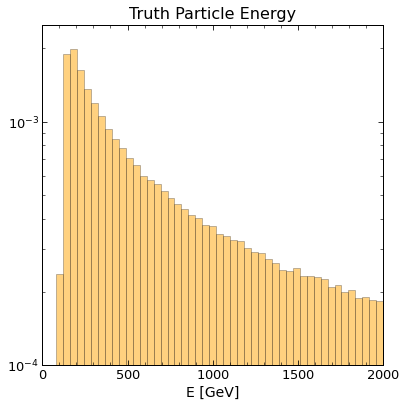

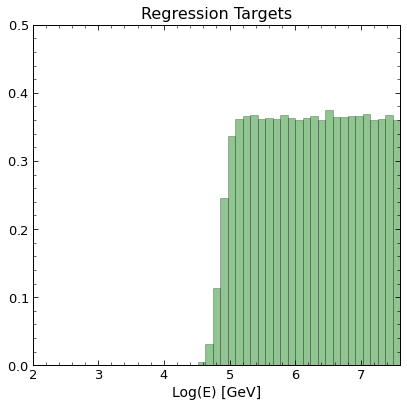

In [5]:
## RAW DATA ##
#=================================================================
fig = plt.figure(figsize=(6,6))
bins=np.linspace(0,2000,50,endpoint=True)
plt.hist(Yreg[:,0], color='orange', bins=bins, density=True, alpha=.5, edgecolor='black',
        label='Particle Truth Energy')
plt.title('Truth Particle Energy', fontsize=16)
plt.xlabel('E [GeV]', fontsize=14)
plt.xlim(np.min(bins),np.max(bins))
plt.yscale('log')
plt.ylim(.0001,.0025)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/November21/EnergyTargets_PIPMnoEM_log_2021-11-22.png', format='png')
plt.show()

## NORMALIZED DATA ##
#=================================================================
fig = plt.figure(figsize=(6,6))
bins=np.linspace(np.log(np.exp(2)), np.log(2000), 50, endpoint=True)
plt.hist(Y, color='forestgreen', bins=bins, density=True, alpha=.5, edgecolor='black',
        label='log')
plt.title('Regression Targets', fontsize=16)
plt.xlabel('Log(E) [GeV]', fontsize=14)
plt.xlim(np.min(bins),np.max(bins))
plt.ylim(0,.5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/November21/EnergyTargets_PIPMnoEM_log_2021-11-22.png', format='png')
plt.show()

### Normalize Inputs

In [6]:
t0 = cput()
## Normalize rPerp to 1/3630
rPerp_mask = X[:,:,3] != 0
X[rPerp_mask,3] = X[rPerp_mask,3]/3630.

## Energy Values that are not zero!
Enz_mask = X[:,:,0] != 0
X[Enz_mask,0] = np.log(X[Enz_mask,0])
cellE_mean = np.mean(X[Enz_mask,0])
cellE_std = np.std(X[Enz_mask,0])
X[Enz_mask,0] = (X[Enz_mask,0] - cellE_mean)/cellE_std
print(cellE_std)

## Eta and Phi
# eta_mask = X[:,:,1] != 0
X[rPerp_mask,1] = X[rPerp_mask,1]/.7

# phi_mask = X[:,:,2] != 0
cellPhi_std = np.std(X[rPerp_mask,2])
X[rPerp_mask,2] = X[rPerp_mask,2]/cellPhi_std
t1 = cput()

print('Time to Normalize: '+str(t1-t0)+' (s)')
print('Time to Normalize: {} (m)'.format((t1-t0)/60))

1.9432123903588694
Time to Normalize: 39.122402821 (s)
Time to Normalize: 0.6520400470166667 (m)


#### Plot Inputs

<Figure size 799.992x599.976 with 0 Axes>

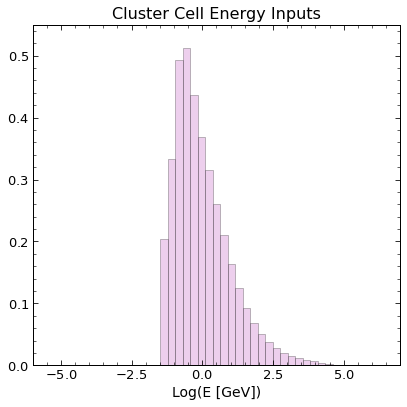

<Figure size 799.992x599.976 with 0 Axes>

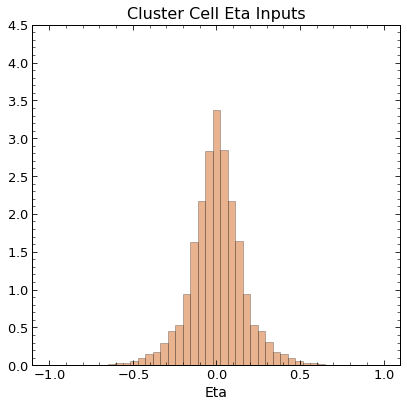

<Figure size 799.992x599.976 with 0 Axes>

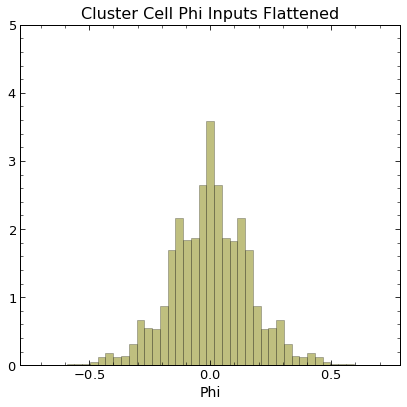

<Figure size 799.992x599.976 with 0 Axes>

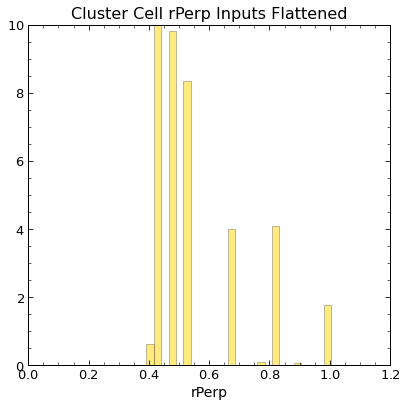

In [7]:
############
## ENERGY ##
############
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
ebins = np.linspace(-6,7, 50, endpoint=True)
plt.hist(X[Enz_mask,0], color='plum', bins=ebins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell Energy Inputs', fontsize=16)
plt.xlabel('Log(E [GeV])', fontsize=14)
plt.xlim(np.min(ebins),np.max(ebins))
plt.ylim(0,.55)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/July/X_STMC_E_2021-07-26.png', format='png')
plt.show()

#########
## ETA ##
#########
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
etabins = np.linspace(-1.1,1.1,50, endpoint=True)
plt.hist(X[rPerp_mask,1], color='chocolate', bins=etabins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell Eta Inputs', fontsize=16)
plt.xlabel('Eta', fontsize=14)
plt.xlim(np.min(etabins),np.max(etabins))
plt.ylim(0,4.5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/July/X_STMC_Eta_2021-07-26.png', format='png')
plt.show()

#########
## PHI ##
#########
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
phibins = np.linspace(-np.pi/4,np.pi/4,50, endpoint=True)
plt.hist(X[rPerp_mask,2], color='olive', bins=phibins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell Phi Inputs Flattened', fontsize=16)
plt.xlabel('Phi', fontsize=14)
plt.xlim(np.min(phibins),np.max(phibins))
plt.ylim(0,5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/July/X_STMC_Phi_2021-07-26.png', format='png')
plt.show()

###########
## RPERP ##
###########
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
Rbins = np.linspace(-0,1.2,50, endpoint=True)
plt.hist(X[rPerp_mask,3], color='gold', bins=Rbins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell rPerp Inputs Flattened', fontsize=16)
plt.xlabel('rPerp', fontsize=14)
plt.xlim(np.min(Rbins),np.max(Rbins))
plt.ylim(0,10)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/July/X_STMC_rPerp_2021-07-26.png', format='png')
plt.show()

## Build Model

In [8]:
def point_mask_fn(X, mask_val=0.):
    return K.cast(K.any(K.not_equal(X, mask_val), axis=-1), K.dtype(X))

def ParticleFlow_base(num_points, num_features, name="Russell Flow Network"):
    
    inputs = keras.Input(shape=(num_points, num_features), name='input')

    dense_0 = layers.Dense(100)
    t_dist_0 = layers.TimeDistributed(dense_0, name='t_dist_0')(inputs)
    activation_0 = layers.Activation('relu', name="activation_0")(t_dist_0)
    
    dense_1 = layers.Dense(100)
    t_dist_1 = layers.TimeDistributed(dense_1, name='t_dist_1')(activation_0)
    activation_1 = layers.Activation('relu', name='activation_1')(t_dist_1)
    
    dense_2 = layers.Dense(128)
    t_dist_2 = layers.TimeDistributed(dense_2, name='t_dist_2')(activation_1)
    activation_2 = layers.Activation('relu', name='activation_2')(t_dist_2)
    
    masking_layer = layers.Masking(mask_value=0.0)
    
    lambda_layer = layers.Lambda(point_mask_fn, output_shape=(None, None),
                                mask=None,
                                name='mask')(inputs)

    sum_layer = layers.Dot(axes=(1,1), name='sum')([lambda_layer, activation_2])
    
    dense_3 = layers.Dense(100, name='dense_0')(sum_layer)
    activation_3 = layers.Activation('relu', name="activation_3")(dense_3)
    
    dense_4 = layers.Dense(100, name='dense_1')(activation_3)
    activation_4 = layers.Activation('relu', name="activation_4")(dense_4)
    
    dense_5 = layers.Dense(100, name='dense_2')(activation_4)
    activation_5 = layers.Activation('relu', name="activation_5")(dense_5)
    
    dense_6 = layers.Dense(1, name='output')(activation_5)
    activation_6 = layers.Activation('relu', name="activation_6")(dense_6)
    
    return keras.Model(inputs=inputs, outputs=activation_6, name=name)

In [9]:
base_model = ParticleFlow_base(num_features=4, num_points=X.shape[1],
                               name='Base_PFN')
base_model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001))
base_model.summary()

2022-01-18 16:59:58.790522: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-01-18 16:59:58.790603: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9672 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:89:00.0, compute capability: 7.5


Model: "Base_PFN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 1117, 4)]    0                                            
__________________________________________________________________________________________________
t_dist_0 (TimeDistributed)      (None, 1117, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_0 (Activation)       (None, 1117, 100)    0           t_dist_0[0][0]                   
__________________________________________________________________________________________________
t_dist_1 (TimeDistributed)      (None, 1117, 100)    10100       activation_0[0][0]               
___________________________________________________________________________________________

## Data Handling

In [10]:
# EFN regression example uses 75/10/15 split for 100,000 samples
train, val, test = dsu.tvt_num(X, tvt=(70, 15, 15))
print('train -- val -- test')
print('{} -- {} -- {}'.format(train, val, test))

train -- val -- test
195462 -- 41885 -- 41885


### Shuffle Data

In [11]:
# t0 = cput()
# indices = np.arange(X.shape[0], dtype=int)
# np.random.shuffle(indices)
# X = X[indices,:,:]
# Y = Y[indices]
# t1 = cput()

# print('Time to shuffle: {} (m)'.format((t1-t0)/60))

### Train/Val/Test Split

In [12]:
X_train = X[:train,:,:]
Y_train = Y[:train]

X_val = X[train:train+val,:,:]
Y_val = Y[train:train+val]

X_test = X[train+val:,:,:]
Y_test = Y[train+val:]

# Print out tensor shapes
print(np.shape(X_train))
print(np.shape(Y_train))
Y_train = np.reshape(Y_train, (Y_train.shape[0], 1))
print(np.shape(Y_train))

(195462, 1117, 4)
(195462,)
(195462, 1)


## Train Model

In [13]:
num_epoch = 100
batch_size = 900

In [14]:
t0 = cput()
history_base = base_model.fit(X_train, Y_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=(X_val, Y_val),
        verbose=1)
t1 = cput()

2022-01-18 17:00:09.320379: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
218/218 [==============================] - 17s 69ms/step - loss: 4.3567 - val_loss: 0.6130
Epoch 2/100
218/218 [==============================] - 13s 58ms/step - loss: 0.5163 - val_loss: 0.4340
Epoch 3/100
218/218 [==============================] - 13s 60ms/step - loss: 0.3076 - val_loss: 0.2053
Epoch 4/100
218/218 [==============================] - 13s 60ms/step - loss: 0.2491 - val_loss: 0.2034
Epoch 5/100
218/218 [==============================] - 13s 61ms/step - loss: 0.2127 - val_loss: 0.1433
Epoch 6/100
218/218 [==============================] - 13s 62ms/step - loss: 0.1428 - val_loss: 0.1351
Epoch 7/100
218/218 [==============================] - 14s 62ms/step - loss: 0.1369 - val_loss: 0.1014
Epoch 8/100
218/218 [==============================] - 13s 60ms/step - loss: 0.1118 - val_loss: 0.1175
Epoch 9/100
218/218 [==============================] - 13s 60ms/step - loss: 0.0948 - val_loss: 0.1040
Epoch 10/100
218/218 [==============================] - 13s 61ms/step - l

In [15]:
print('Time to train: {} (s)'.format(t1-t0))
print('{} (min)'.format((t1-t0)/60))
print('{} (hour)'.format((t1-t0)/3600))

Time to train: 1427.514347731 (s)
23.791905795516666 (min)
0.3965317632586111 (hour)


### Loss Curves

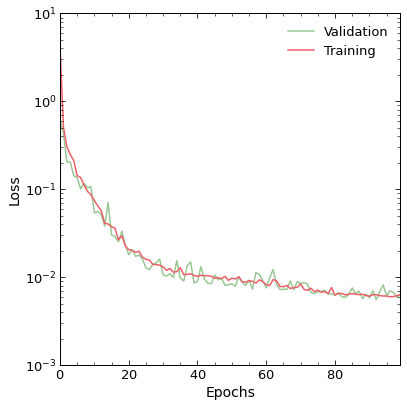

In [16]:
fig = plt.figure(figsize=(6,6))
plt.plot(history_base.history['val_loss'], label="Validation")
plt.plot(history_base.history['loss'], label="Training")
plt.yscale('log')
# plt.ylim(.001,10)
plt.yticks(fontsize=13)
plt.xlim(0,len(history_base.history['loss'])-1)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', ncol=1)
# plt.text(1000, 1.5, 'LR=1e-3', fontsize=13)
# plt.text(1000, 1, 'Batch: 3000', fontsize=13)
plt.tight_layout()
# plt.savefig('Regression_Plots/November21/pipmNoEM_lossCurves_3000batch_LR1e-3_2021-11-29.png', format='png')
plt.show()

### Predictions

In [22]:
base_preds = base_model.predict(X_test, batch_size=batch_size).flatten()
print(base_preds.shape)

(41885,)


In [29]:
print(base_preds)
print(Y_test[:100])

[5.5034995 6.669984  6.221882  ... 4.917405  7.1752176 6.0882936]
[5.45533292 6.7144316  6.16673335 5.34432198 6.39630914 6.97038834
 6.87197579 5.60154727 5.97871841 5.13961795 5.4246183  6.19228473
 6.82484287 5.11258482 5.24096682 7.18353436 6.03287331 7.44382024
 5.21680346 5.42313944 5.48471373 6.42592288 7.35566778 6.58339656
 6.62201712 5.99028427 4.99805661 6.0444324  5.77974573 5.30397478
 5.10577123 6.91139957 6.22859154 6.12260999 7.0391256  6.09673452
 5.273528   5.40737545 4.61881199 6.31312005 5.45679986 5.13579188
 5.99182024 6.71313477 5.78756602 6.40257379 5.81854119 6.53497911
 6.44508844 7.18187643 7.20767702 5.42016892 5.42176683 6.17122125
 6.14613953 5.35157013 7.23515626 6.97793885 6.08058956 5.95723048
 6.94164034 6.39979674 6.34518663 4.77676181 6.94514032 7.52652376
 6.78265428 4.90239441 7.57045181 5.39515621 6.88543677 5.89453961
 7.13402548 6.88206925 6.87049678 6.26063636 6.14564385 5.19996156
 6.5351836  5.90038669 5.53448854 7.53888822 7.27597019 5.00107

In [28]:
print(np.exp(5))

148.4131591025766


### Histogram of Predictions

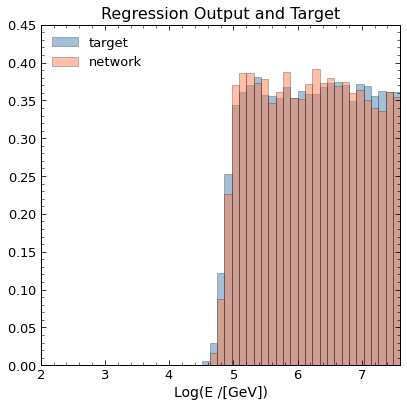

In [25]:
## PREDICTIONS AND TRUTH ##
bins = np.linspace(2,np.log(2000),50, endpoint=True)
fig = plt.figure(figsize=(6,6))
plt.hist(Y_test, color='steelblue', bins=bins, density=True, alpha=.5, edgecolor='black', label='target')
plt.hist(base_preds, color='coral', bins=bins, density=True, alpha=.5, edgecolor='black', label='network')
plt.title('Regression Output and Target', fontsize=16)
plt.xlabel('Log(E /[GeV])', fontsize=14)
plt.xlim(2,np.log(2000))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('Regression_Plots/November21/NoEMtargetPreds_3000batch_LR1e-3_2021-11-29.png', format='png')
plt.show()

## Analytics

### Response Plots

<Figure size 799.992x599.976 with 0 Axes>

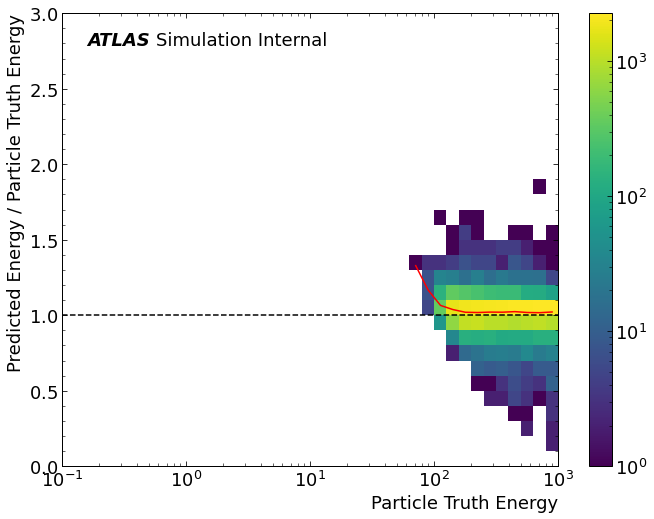

In [26]:
resplot = ru.responsePlot(x=np.exp(Y_test), y=np.exp(base_preds)/np.exp(Y_test),
                figfile='',
                statistic='median', xlabel='Particle Truth Energy', ylabel='Predicted Energy / Particle Truth Energy',
                atlas_x=.05, atlas_y=.96, simulation=True, cblabel='',
                textlist=[])

# Regression_Plots/November21/ResponsePlotNoEM_3000batch_LR1e-3_2021-11-29.png

### Resolution Plots

<Figure size 799.992x599.976 with 0 Axes>

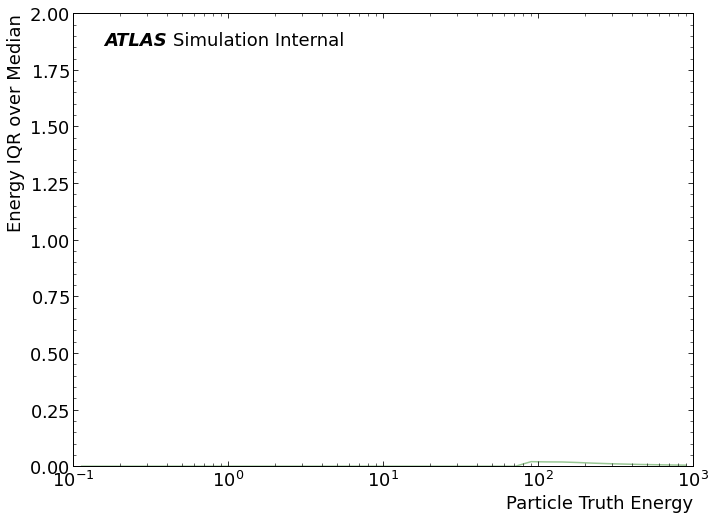

In [35]:
resp_plot = ru.resolutionPlot(x=np.exp(Y_test), y=10*base_preds/np.exp(Y_test),
                    figfile='Regression_Plots/November21/ResolutionPlotNoEM_3000batch_LR1e-3_2021-11-29.png',
                    statistic='std', xlabel='Particle Truth Energy', ylabel='Energy IQR over Median',
                    atlas_x=.05, atlas_y=.96, simulation=True,
                    textlist=[])

